<a href="https://colab.research.google.com/github/henriqueburis/Classification_Remote_Sensing_UCMerced/blob/main/pixforce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Deep learning CNN-VGG

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip /content/drive/MyDrive/UCMerced_LandUse_pixforce_threeClasse.zip

In [ ]:
!rm -rf /content/UCMerced_LandUse_pixforce_threeClasse

In [ ]:
!pip install tensorboardX

In [ ]:
import os
import torch
import argparse
import numpy as np
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, TensorDataset
from tensorboardX import SummaryWriter
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from sklearn.manifold import TSNE
import seaborn as sns

In [ ]:
print("==> Parametre data")
img_size = 256
batch_size = 32
batch_size_inferencia = 1
n_classe = 0
epoch = 50 #200

path_train = "/content/UCMerced_LandUse_pixforce_threeClasse/train"
path_test = "/content/UCMerced_LandUse_pixforce_threeClasse/Images"
save_dir = "/content/drive/MyDrive/results"

==> Parametre data


In [ ]:
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.Resize((img_size,img_size)),
    #transforms.RandomCrop(32, padding=4), # testar sem o randomcrop.
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.Resize((img_size,img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


trainset = datasets.ImageFolder(os.path.abspath(path_train), transform=transform_train)

train, valid = torch.utils.data.random_split(trainset,[243,27]) #10%test

train_loader = torch.utils.data.DataLoader(train,
                                          batch_size=batch_size,
                                          shuffle=True, num_workers=0)

val_loader = torch.utils.data.DataLoader(valid,
                                          batch_size=batch_size,
                                          shuffle=False, num_workers=0)

testset = datasets.ImageFolder(os.path.abspath(path_test), transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size_inferencia,
                                         shuffle=False, num_workers=0)



==> Preparing data..


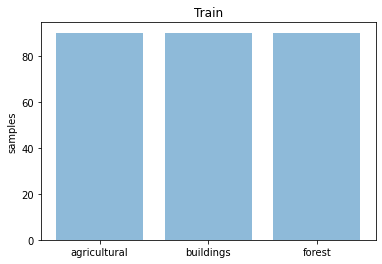

Classe do treinamento==)> ['agricultural', 'buildings', 'forest']
Num_ Classe==)> 3
Dataset Train 243
Dataset Val 27
------------------------------------------------
==> Preparing data Done..


In [ ]:
classes =  train_loader.dataset.dataset.classes
num_label = train_loader.dataset.dataset.targets
n_classe = len(classes)
a = num_label.count(0)
b = num_label.count(1)
c = num_label.count(2)
y_pos = np.arange(len(classes))
performance = [a,b,c]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, classes)
plt.ylabel('samples')
plt.title('Train')
plt.show()
print("Classe do treinamento==)>",classes)
print("Num_ Classe==)>",n_classe)
print("Dataset Train",len(train_loader.dataset.indices))
print("Dataset Val",len(val_loader.dataset.indices))
print("------------------------------------------------")
print('==> Preparing data Done..')

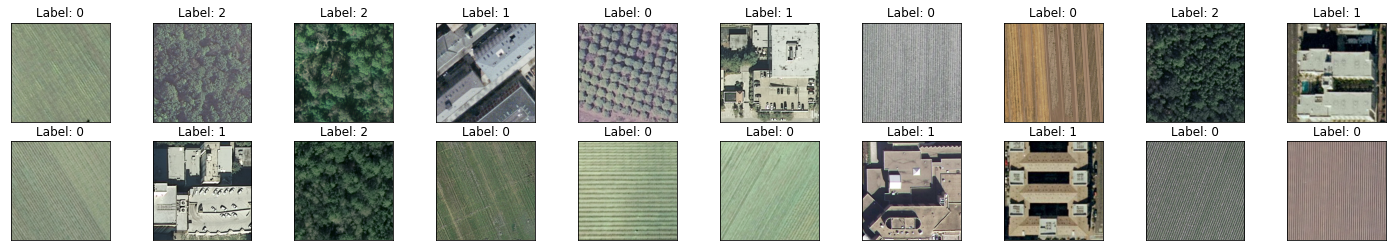

In [ ]:
fig = plt.figure(figsize=(25, 4))

for idx in range(0, 20):
  random_ = np.random.choice(train_loader.sampler.num_samples)
  ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
  im = Image.open(train_loader.sampler.data_source.dataset.imgs[random_][0])
  plt.imshow(im)
  lab = train_loader.sampler.data_source.dataset.imgs[random_][1]
  ax.set_title(f'Label: {lab}')


https://pytorch.org/vision/0.12/generated/torchvision.models.vgg19.html

In [ ]:
print('==> Building model..')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#net = models.resnet50(pretrained=True)
#net = torchvision.models.vgg16(pretrained=True)
net = torchvision.models.vgg19(weights='VGG19_Weights.IMAGENET1K_V1')
net.classifier[6] = nn.Linear(4096,n_classe) # utilizado no vggs

#modules = list(net.children())[:-1]
#modules.append(nn.Flatten())
#modules.append(nn.Linear(net.fc.in_features,args.n_classe))
#net = nn.Sequential(*modules)
net = net.to(device)

print("-------------------")
print(device)

==> Building model..


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

-------------------
cuda


https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

In [ ]:
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

criterion_cnn = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(net.parameters(), lr=0.00001)

In [ ]:
def save_model(model):
    torch.save(model.state_dict(), save_dir + "/""pixforce_model.pt")

def CreateDir(path):
        try:
                os.mkdir(path)
        except OSError as error:
                print(error)

In [ ]:
CreateDir(save_dir)

In [ ]:
print('==> Preparing tensorboard..')
writer = SummaryWriter(save_dir)

==> Preparing tensorboard..


In [ ]:
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer_cnn.zero_grad()
        outputs = net(inputs)
        loss = criterion_cnn(outputs, targets)# criterion
        loss.backward()
        optimizer_cnn.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        writer.add_scalar('Training/ACC_',100.*correct/total, (epoch*len(train_loader.dataset)/batch_size)+batch_idx)
        writer.add_scalar('Training/loss_',train_loss/(batch_idx+1),(epoch*len(train_loader.dataset)/batch_size)+batch_idx)
    print('\n %d',correct/total*100)
    writer.add_scalar('Training/ACC',correct/total*100, epoch)

In [ ]:
def val():
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            _, predicted = outputs.max(1)

            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    acc = 100.*correct/total
    print("ACC_test",acc)

In [ ]:
for epoch in range(0, epoch):
  train(epoch)

print("--------------")
val()
save_model(net)



Epoch: 0

 %d 56.79012345679012

Epoch: 1

 %d 98.35390946502058

Epoch: 2

 %d 99.1769547325103

Epoch: 3

 %d 99.58847736625515

Epoch: 4

 %d 100.0

Epoch: 5

 %d 100.0

Epoch: 6

 %d 100.0

Epoch: 7

 %d 100.0

Epoch: 8

 %d 100.0

Epoch: 9

 %d 100.0

Epoch: 10

 %d 100.0

Epoch: 11

 %d 100.0

Epoch: 12

 %d 100.0

Epoch: 13

 %d 100.0

Epoch: 14

 %d 100.0

Epoch: 15

 %d 100.0

Epoch: 16

 %d 100.0

Epoch: 17

 %d 100.0

Epoch: 18

 %d 100.0

Epoch: 19

 %d 100.0

Epoch: 20

 %d 100.0

Epoch: 21

 %d 100.0

Epoch: 22

 %d 100.0

Epoch: 23

 %d 100.0

Epoch: 24

 %d 100.0

Epoch: 25

 %d 100.0

Epoch: 26

 %d 100.0

Epoch: 27

 %d 100.0

Epoch: 28

 %d 100.0

Epoch: 29

 %d 100.0

Epoch: 30

 %d 100.0

Epoch: 31

 %d 100.0

Epoch: 32

 %d 100.0

Epoch: 33

 %d 100.0

Epoch: 34

 %d 100.0

Epoch: 35

 %d 100.0

Epoch: 36

 %d 100.0

Epoch: 37

 %d 100.0

Epoch: 38

 %d 100.0

Epoch: 39

 %d 100.0

Epoch: 40

 %d 100.0

Epoch: 41

 %d 100.0

Epoch: 42

 %d 100.0

Epoch: 43

 %d 1

0
agricultural
/content/UCMerced_LandUse_pixforce_threeClasse/Images/test/agricultural00.tif


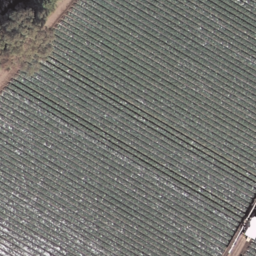

1
agricultural
/content/UCMerced_LandUse_pixforce_threeClasse/Images/test/agricultural11.tif


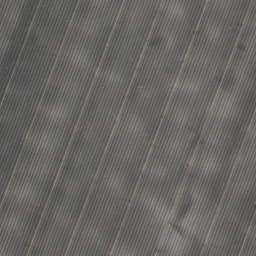

2
agricultural
/content/UCMerced_LandUse_pixforce_threeClasse/Images/test/agricultural22.tif


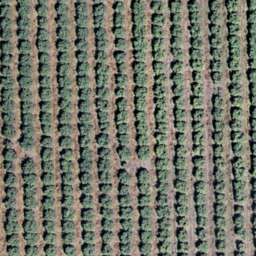

3
agricultural
/content/UCMerced_LandUse_pixforce_threeClasse/Images/test/agricultural33.tif


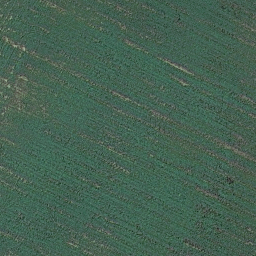

4
agricultural
/content/UCMerced_LandUse_pixforce_threeClasse/Images/test/agricultural44.tif


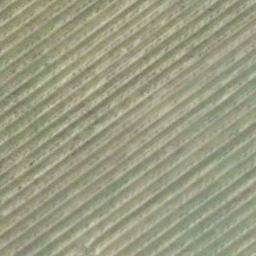

5
agricultural
/content/UCMerced_LandUse_pixforce_threeClasse/Images/test/agricultural55.tif


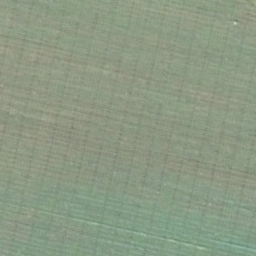

6
agricultural
/content/UCMerced_LandUse_pixforce_threeClasse/Images/test/agricultural66.tif


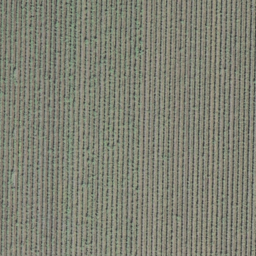

7
agricultural
/content/UCMerced_LandUse_pixforce_threeClasse/Images/test/agricultural77.tif


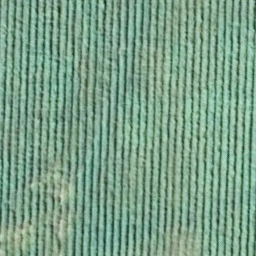

8
agricultural
/content/UCMerced_LandUse_pixforce_threeClasse/Images/test/agricultural88.tif


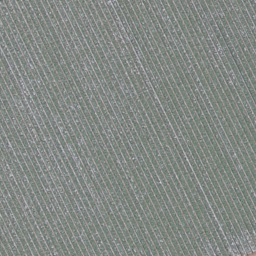

9
agricultural
/content/UCMerced_LandUse_pixforce_threeClasse/Images/test/agricultural99.tif


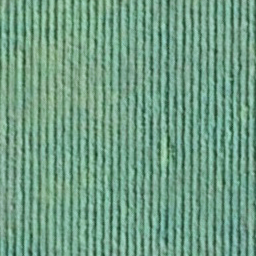

10
buildings
/content/UCMerced_LandUse_pixforce_threeClasse/Images/test/buildings00.tif


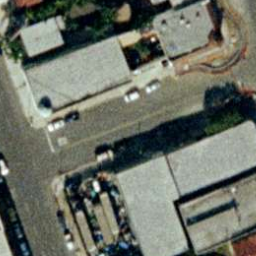

11
buildings
/content/UCMerced_LandUse_pixforce_threeClasse/Images/test/buildings11.tif


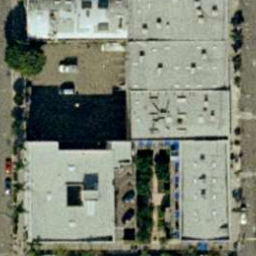

12
buildings
/content/UCMerced_LandUse_pixforce_threeClasse/Images/test/buildings22.tif


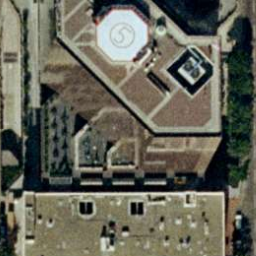

13
buildings
/content/UCMerced_LandUse_pixforce_threeClasse/Images/test/buildings33.tif


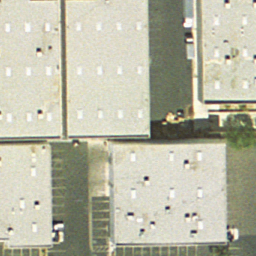

14
buildings
/content/UCMerced_LandUse_pixforce_threeClasse/Images/test/buildings44.tif


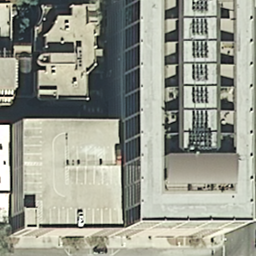

15
buildings
/content/UCMerced_LandUse_pixforce_threeClasse/Images/test/buildings55.tif


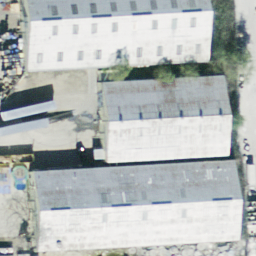

16
buildings
/content/UCMerced_LandUse_pixforce_threeClasse/Images/test/buildings66.tif


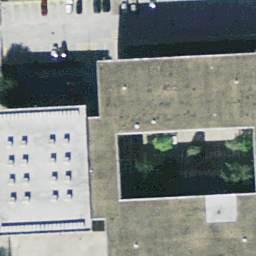

17
buildings
/content/UCMerced_LandUse_pixforce_threeClasse/Images/test/buildings77.tif


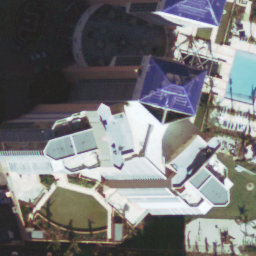

18
buildings
/content/UCMerced_LandUse_pixforce_threeClasse/Images/test/buildings88.tif


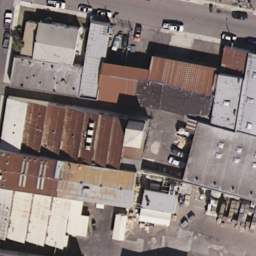

19
buildings
/content/UCMerced_LandUse_pixforce_threeClasse/Images/test/buildings99.tif


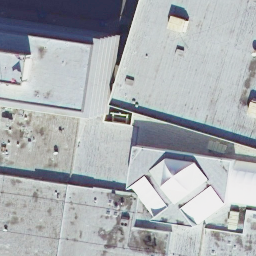

20
forest
/content/UCMerced_LandUse_pixforce_threeClasse/Images/test/forest00.tif


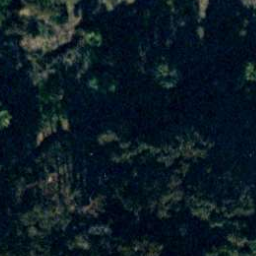

21
forest
/content/UCMerced_LandUse_pixforce_threeClasse/Images/test/forest11.tif


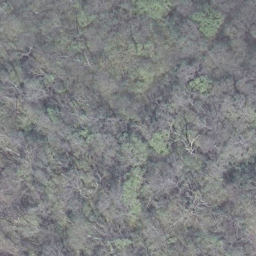

22
forest
/content/UCMerced_LandUse_pixforce_threeClasse/Images/test/forest22.tif


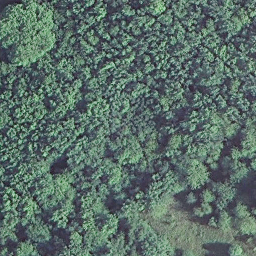

23
forest
/content/UCMerced_LandUse_pixforce_threeClasse/Images/test/forest33.tif


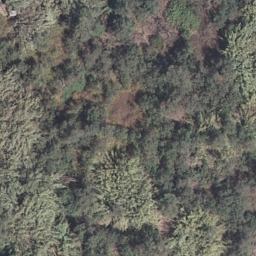

24
forest
/content/UCMerced_LandUse_pixforce_threeClasse/Images/test/forest44.tif


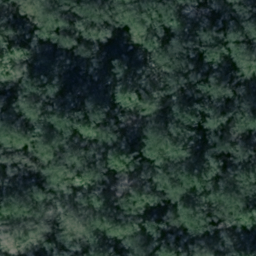

25
forest
/content/UCMerced_LandUse_pixforce_threeClasse/Images/test/forest55.tif


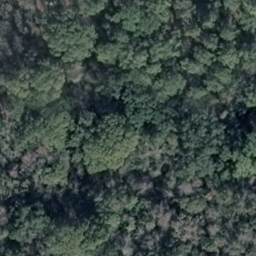

26
forest
/content/UCMerced_LandUse_pixforce_threeClasse/Images/test/forest66.tif


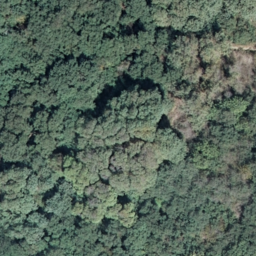

27
forest
/content/UCMerced_LandUse_pixforce_threeClasse/Images/test/forest77.tif


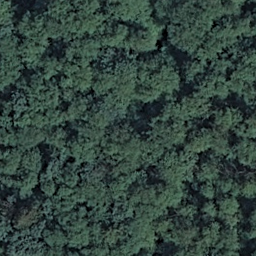

28
forest
/content/UCMerced_LandUse_pixforce_threeClasse/Images/test/forest88.tif


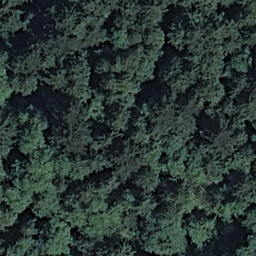

29
forest
/content/UCMerced_LandUse_pixforce_threeClasse/Images/test/forest99.tif


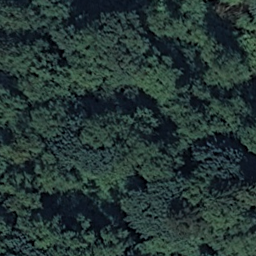

In [ ]:
for idx, (inputs, targets) in enumerate(test_loader):
  inputs = inputs.to(device)
  outputs = net(inputs)
  _, predicted = outputs.max(1)
  print(idx)
  print(train_loader.dataset.dataset.classes[int(predicted.cpu().item())])
  print(test_loader.dataset.imgs[idx][0])
  imInfere = Image.open(test_loader.dataset.imgs[idx][0])
  display(imInfere)


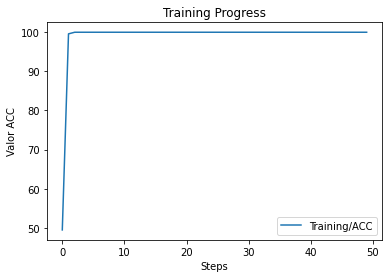

-----------------


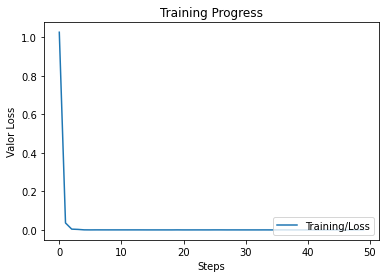

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator


def plot_tensorflow_log(path, eventS):

    # Loading too much data is slow...
    tf_size_guidance = {
        'compressedHistograms': 10,
        'images': 0,
        'scalars': 50,
        'histograms': 1
    }

    event_acc = EventAccumulator(path, tf_size_guidance)
    event_acc.Reload()

    # Show all tags in the log file
    #print(event_acc.Tags())

    training_accuracies =   event_acc.Scalars(eventS)

    steps = 50
    x = np.arange(steps)
    y = np.zeros([steps, 2])

    for i in range(steps):
        y[i, 0] = training_accuracies[i][2] # value

    return x, y

def plot_(x,y,type_):
    
    plt.plot(x, y[:,0], label='Training/'+type_)

    plt.xlabel("Steps")
    plt.ylabel("Valor "+type_)
    plt.title("Training Progress")
    plt.legend(loc='lower right', frameon=True)
    plt.show()


if __name__ == '__main__':
    log_file = "/content/drive/MyDrive/results"
    x , y = plot_tensorflow_log(log_file,'Training/ACC_')
    plot_(x,y,"ACC")
    print("-----------------")
    x , y = plot_tensorflow_log(log_file,'Training/loss_')
    plot_(x,y,"Loss")


In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          titleG='Confusion matrix',
                          cmap=None,
                          normalize=True):
 
    import matplotlib.pyplot as plt_
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt_.get_cmap('Blues')

    plt_.figure()
    plt_.imshow(cm, interpolation='nearest', cmap=cmap)
    plt_.title(titleG)
    plt_.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt_.xticks(tick_marks, target_names, rotation=45)
        plt_.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt_.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt_.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt_.tight_layout()
    plt_.ylabel('Verdade do label')
    plt_.xlabel('Predicted label')
    plt_.xlabel('Predição do  label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    #plt_.savefig(title+'-confusion_matrix.png', dpi=120)
    plt.show() 
    plt_.close()
    

In [ ]:
def convert_label_(pred_y,true_l,list_label):
  y_true = []
  y_pred = []
  for i in range(len(pred_y)):
    for j in range(len(pred_y[i])):
      y_pred.append(list_label[pred_y[i][j].item()])
      y_true.append(list_label[true_l[i][j].item()])
  return np.array(y_true),np.array(y_pred)

In [ ]:
def MC_val():
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    pred_ = []
    label_ = []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            _, predicted = outputs.max(1)
            
            pred_.append(predicted.data.cpu().numpy())
            label_.append(targets.data.cpu().numpy())
            
        return pred_, label_

[[ 7  0  0]
 [ 0 11  0]
 [ 0  0  9]]


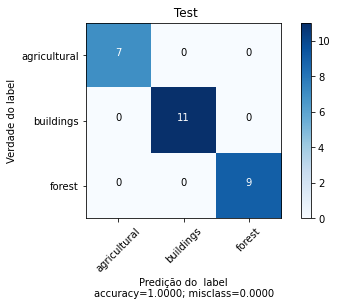

In [ ]:
from sklearn.metrics import confusion_matrix

pred, label = MC_val()

y_pred, y_true = convert_label_(pred,label,classes)
confusion = confusion_matrix(y_true, y_pred, labels = classes)

print(confusion)
plot_confusion_matrix(cm = np.array(confusion),normalize = False, target_names = classes, title =' Test', titleG = ' Test')